## Cross-correlating with matlab file to check 

In [1]:
# import the package
from NeuralProcessor import *

In [2]:
## filepaths and names, change this to your file location. 
data_path = '/Users/seonghyunyoon/Developer/nptl/lower_frequencies/Data'
filename1 = 't12_t12.2022.08.13_Data__NSP1_NSP Data_1_neuralProcess_Complete_bld(001)002.ns5'
filename2 = 't12_t12.2022.08.13_Data__NSP2_NSP Data_1_neuralProcess_Complete_bld(001).ns5'
redis_file = 't12_t12.2022.08.13_Data_RedisMat_20220813_082609.mat'

raw_neural1, audio = read_ns5_file(f'{data_path}/{filename1}', n_channels=128, include_audio=True)
raw_neural2 = read_ns5_file(f'{data_path}/{filename2}', n_channels=128, include_audio=False)
processed = loadmat(f'{data_path}/{redis_file}')


t12_t12.2022.08.13_Data__NSP1_NSP Data_1_neuralProcess_Complete_bld(001)002.ns5 opened

t12_t12.2022.08.13_Data__NSP1_NSP Data_1_neuralProcess_Complete_bld(001)002.ns5 closed

t12_t12.2022.08.13_Data__NSP2_NSP Data_1_neuralProcess_Complete_bld(001).ns5 opened

t12_t12.2022.08.13_Data__NSP2_NSP Data_1_neuralProcess_Complete_bld(001).ns5 closed


In [3]:
# Replicate the method used in Willet et al (2023)
# Outlined in https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-023-06377-x/MediaObjects/41586_2023_6377_MOESM1_ESM.pdf

processor_params = {
    "processes": [
        ChevyshevFilter("lowpass", Wn=[6000], rp=0.05, ord=8, fs=30000, non_causal=True),
        Downsampler(ds_factor=2), 
        ButterworthFilter("bandpass", Wn=[250, 4900], ord=4, fs=30000, non_causal=True), 
        ReReferenceFilter("lrr", max_seconds=60)
    ], 
    "thresh_mults": [-4.5], 
    "thresh_method": "std",
    "spike_pow_bands": ['full'], 
    "bin_size": 20,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 20,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
}

Processor = NeuralProcessor(processor_params)

In [4]:
arr1_20ms = Processor(raw_neural1, n_arrays=1, n_electrodes=128, fs=30000, verbose=True)
arr2_20ms = Processor(raw_neural2, n_arrays=1, n_electrodes=128, fs=30000, verbose=True)

Process 0/4 finished
Process 1/4 finished
Process 2/4 finished
Process 3/4 finished
Threshold crossing counts for multipliers [-4.5] extracted
Process 0/4 finished
Process 1/4 finished
Process 2/4 finished
Process 3/4 finished
Threshold crossing counts for multipliers [-4.5] extracted


In [13]:
@nb.jit(nopython=True)
def _normalize(data):
    data = data.astype('float32')
    out = np.zeros(shape=data.shape, dtype='float32')
    n_samples, n_channels = data.shape
    for ch in range(n_channels): 
        mean = np.sum(data[:,ch]) / n_samples
        std = np.std(data[:,ch])
        out[:,ch] = (data[:,ch] - mean) / std
    return out

@nb.jit(nopython=True)
def _euclidean(vec1, vec2): 
    vec1 = vec1.astype('float32')
    vec2 = vec2.astype('float32')
    return np.sqrt(np.sum(np.square(vec1 - vec2)))

@nb.jit(nopython=True)
def _convolve(vec1, vec2): 
    vec1 = vec1.astype('float32')
    vec2 = vec2.astype('float32')
    assert vec1.shape[0] == vec2.shape[0]
    out = 0
    for i in range(vec1.shape[0]): 
        out += vec1[i] * vec2[i]
    return out 
    
@nb.jit(nopython=True)
def cross_correlate(X1, X2, similarity_fun): 
    n_samples1, n_channels = X1.shape 
    n_samples2 = X2.shape[0]
    n_windows = n_samples1 - n_samples2 + 1
    
    X2_norm = _normalize(X2)
    out = np.zeros(shape=(n_windows, n_channels), dtype='float32')

    for offset in range(n_windows): 
        X1_window = X1[offset:offset+n_samples2,:]
        X1_window = _normalize(X1_window)
        for ch in range(n_channels): 
            out[offset, ch] = similarity_fun(X1_window[:,ch], X2_norm[:,ch])
            # out[offset, ch] = _euclidean(X1_window[:,ch], X2[:,ch])
    return out 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(processed['binnedNeural_hlfp'].flatten(), bins=[50*i for i in range(200)])
axs[1].hist(np.hstack([arr1_20ms['bandpower_f_uHz'].flatten(), arr2_20ms['bandpower_f_uHz'].flatten()]), bins=[50*i for i in range(200)])
plt.show()

In [18]:
# let us cross correlate the 4 possible scenarios. This will tell us which ns5 file is from 6v, and when the start of the trial is
# we will first cross correlate the spiking bandpower 
n_sample_channels = 128
dist11 = cross_correlate(arr1_20ms['bandpower_f_uHz'][:,:n_sample_channels], processed['binnedNeural_hlfp'][:,:n_sample_channels], _convolve)         # If array 1 channels are same order as first 128 channels in redis file
dist12 = cross_correlate(arr1_20ms['bandpower_f_uHz'][:,:n_sample_channels], processed['binnedNeural_hlfp'][:,128:128+n_sample_channels], _convolve)  # If array 1 channels are same order as last 128 channels in redis file
dist21 = cross_correlate(arr2_20ms['bandpower_f_uHz'][:,:n_sample_channels], processed['binnedNeural_hlfp'][:,:n_sample_channels], _convolve)         # If array 2 channels are same order as first 128 channels in redis file
dist22 = cross_correlate(arr2_20ms['bandpower_f_uHz'][:,:n_sample_channels], processed['binnedNeural_hlfp'][:,128:128+n_sample_channels], _convolve)  # If array 2 channels are same order as last 128 channels in redis file

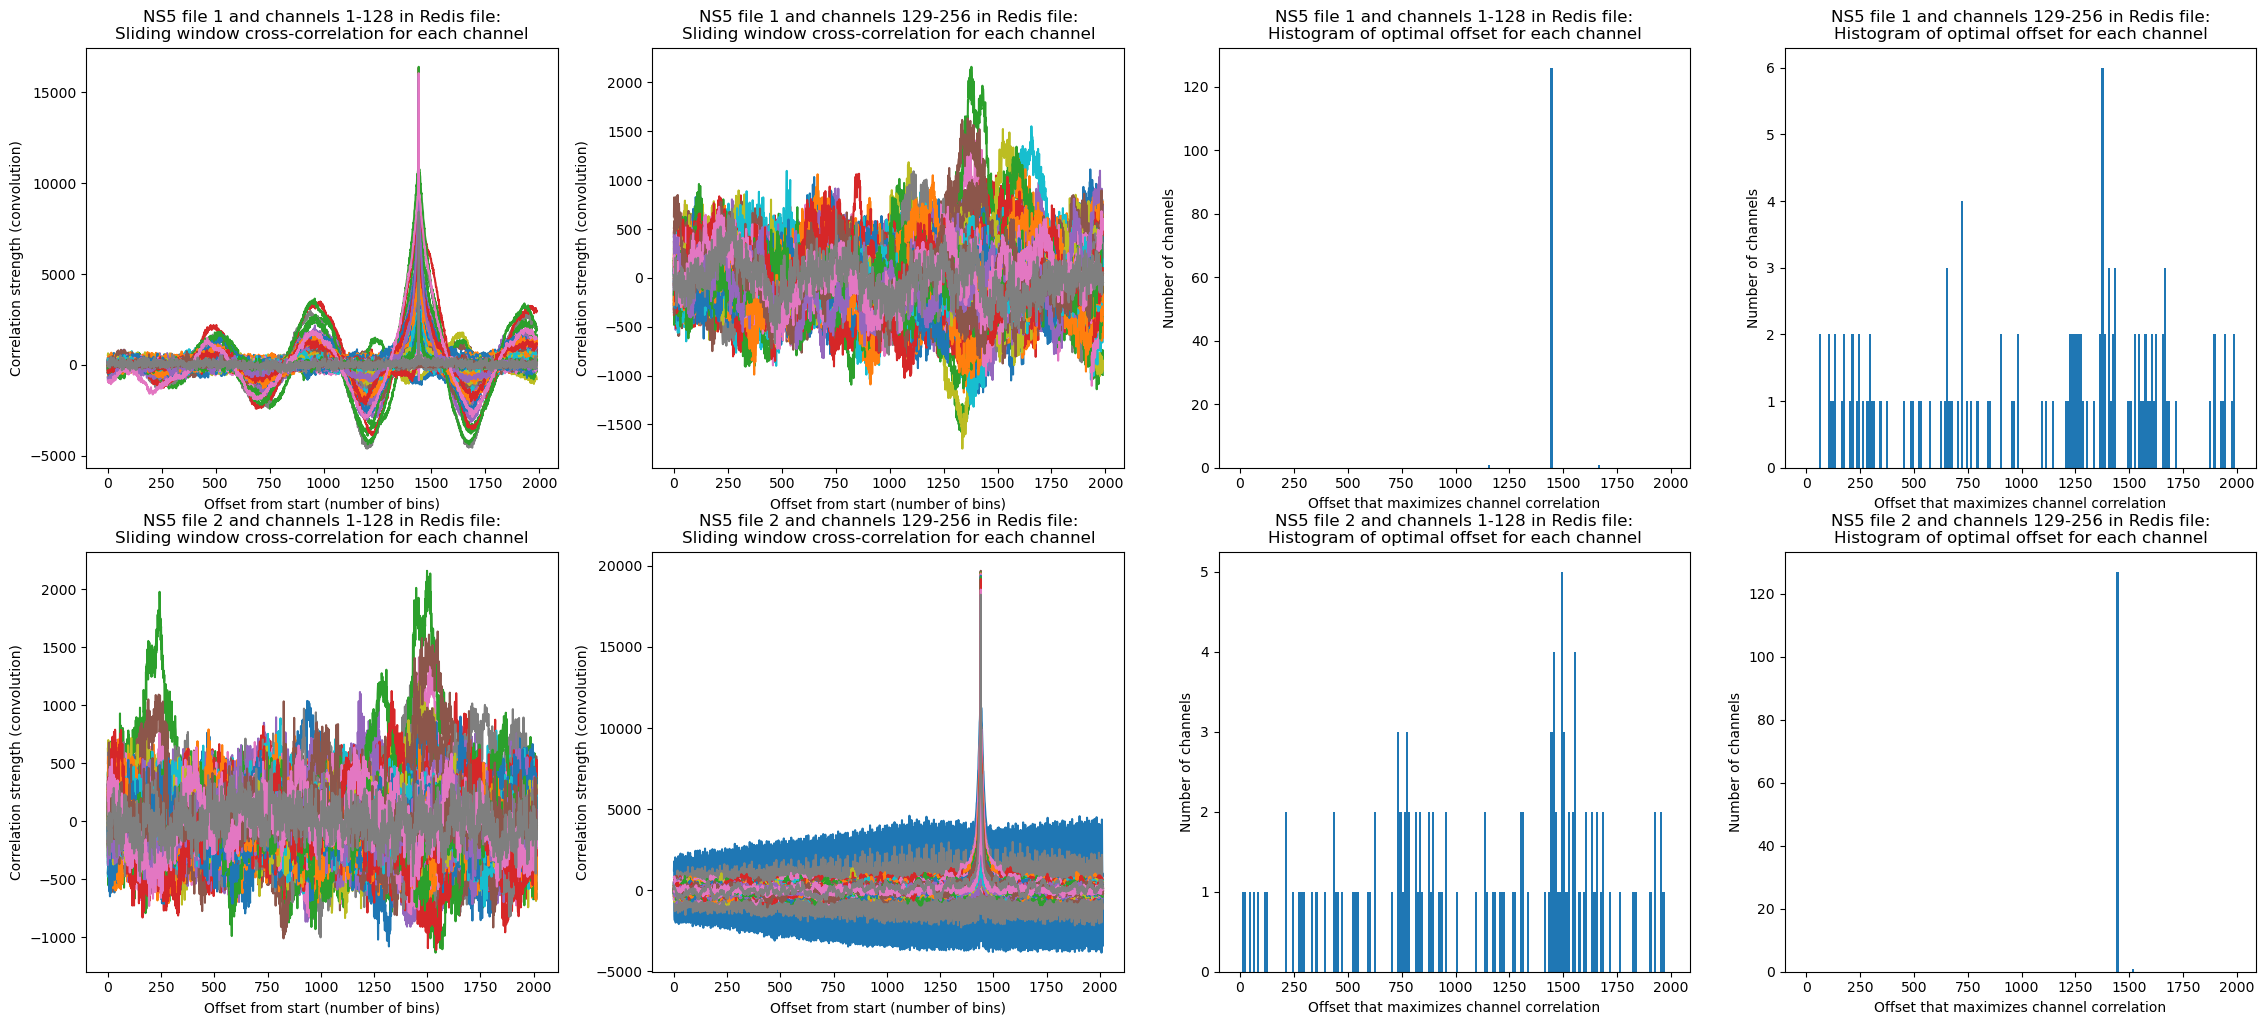

In [95]:
fig, axs = plt.subplots(2, 4, figsize=(28, 12))

n_channels = dist11.shape[1]
for ch in range(n_channels): 
    axs[0, 0].plot(dist11[:,ch])
    axs[0, 0].set_title('NS5 file 1 and channels 1-128 in Redis file:\nSliding window cross-correlation for each channel')
    axs[0, 0].set_xlabel('Offset from start (number of bins)')
    axs[0, 0].set_ylabel('Correlation strength (convolution)')
    
    axs[0, 1].plot(dist12[:,ch])
    axs[0, 1].set_title('NS5 file 1 and channels 129-256 in Redis file:\nSliding window cross-correlation for each channel')
    axs[0, 1].set_xlabel('Offset from start (number of bins)')
    axs[0, 1].set_ylabel('Correlation strength (convolution)')
    
    axs[1, 0].plot(dist21[:,ch])
    axs[1, 0].set_title('NS5 file 2 and channels 1-128 in Redis file:\nSliding window cross-correlation for each channel')
    axs[1, 0].set_xlabel('Offset from start (number of bins)')
    axs[1, 0].set_ylabel('Correlation strength (convolution)')
    
    axs[1, 1].plot(dist22[:,ch])
    axs[1, 1].set_title('NS5 file 2 and channels 129-256 in Redis file:\nSliding window cross-correlation for each channel')
    axs[1, 1].set_xlabel('Offset from start (number of bins)')
    axs[1, 1].set_ylabel('Correlation strength (convolution)')

axs[0, 2].hist(np.argmax(dist11, axis=0), bins=[10*i for i in range(200)])
axs[0, 2].set_title(f'NS5 file 1 and channels 1-128 in Redis file:\nHistogram of optimal offset for each channel')
axs[0, 2].set_xlabel('Offset that maximizes channel correlation')
axs[0, 2].set_ylabel('Number of channels')

axs[0, 3].hist(np.argmax(dist12, axis=0), bins=[10*i for i in range(200)])
axs[0, 3].set_title(f'NS5 file 1 and channels 129-256 in Redis file:\nHistogram of optimal offset for each channel')
axs[0, 3].set_xlabel('Offset that maximizes channel correlation')
axs[0, 3].set_ylabel('Number of channels')

axs[1, 2].hist(np.argmax(dist21, axis=0), bins=[10*i for i in range(200)])
axs[1, 2].set_title(f'NS5 file 2 and channels 1-128 in Redis file:\nHistogram of optimal offset for each channel')
axs[1, 2].set_xlabel('Offset that maximizes channel correlation')
axs[1, 2].set_ylabel('Number of channels')

axs[1, 3].hist(np.argmax(dist22, axis=0), bins=[10*i for i in range(200)])
axs[1, 3].set_title(f'NS5 file 2 and channels 129-256 in Redis file:\nHistogram of optimal offset for each channel')
axs[1, 3].set_xlabel('Offset that maximizes channel correlation')
axs[1, 3].set_ylabel('Number of channels')

plt.show()

# We see that both are maximum at 1441

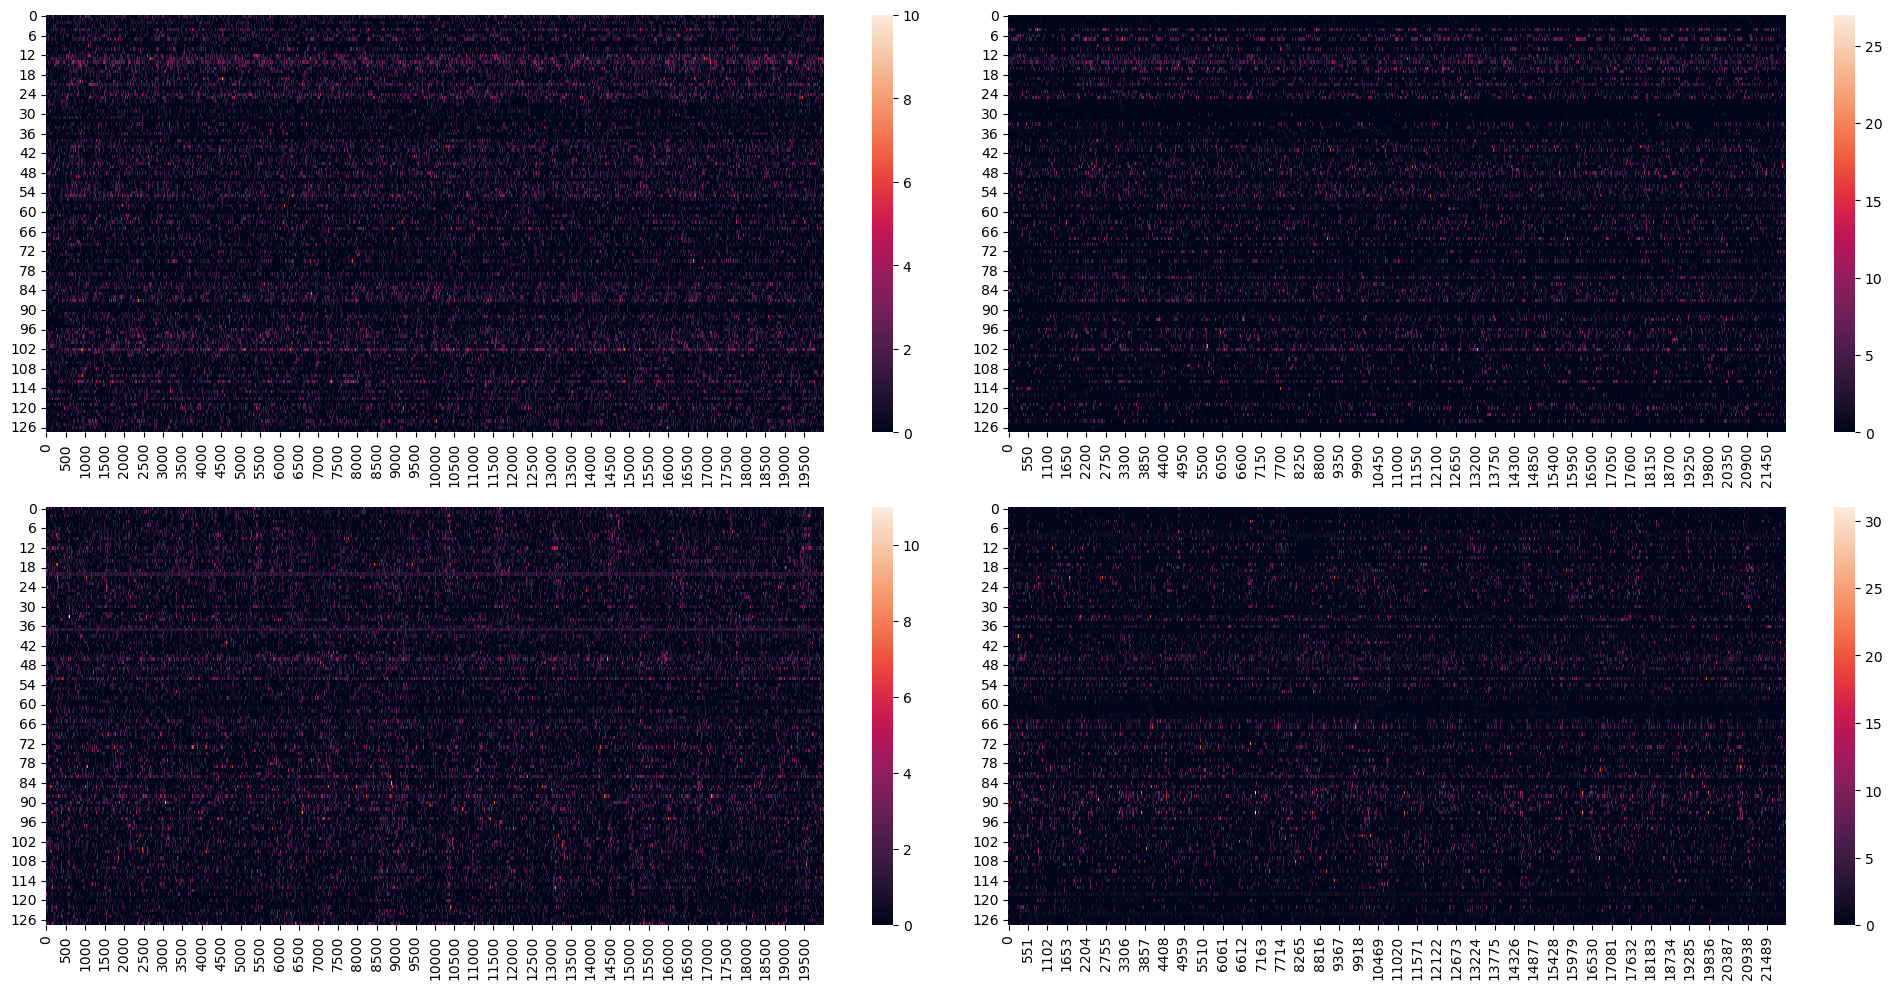

In [96]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.heatmap(ax=axs[0, 0], data=processed['binnedNeural'][:,:128].T)#, cmap='hot')
sns.heatmap(ax=axs[1, 0], data=processed['binnedNeural'][:,128:].T)#, cmap='hot')
sns.heatmap(ax=axs[0, 1], data=np.clip(arr1_20ms['threshold_-4.5'].T, 0, 30))#data=arr1_unscrambled.T)#, cmap='hot')
sns.heatmap(ax=axs[1, 1], data=np.clip(arr2_20ms['threshold_-4.5'].T, 0, 31))#data=arr2_unscrambled.T)#, cmap='hot')
plt.tight_layout()
plt.show()

# Redis file (left)         unscrambled 

In [98]:
# since we are most interested in the similarity of the pattern rather than magnitude, we choose cosine similarity 

@nb.jit(nopython=True)
def _cosine(vec1, vec2): 
    assert vec1.shape[0] == vec2.shape[0]
    AdotB = 0 
    Anorm = 0
    Bnorm = 0
    for i in range(vec1.shape[0]): 
        AdotB += vec1[i] * vec2[i]
        Anorm += vec1[i]**2
        Bnorm += vec2[i]**2
    return AdotB / (np.sqrt(Anorm) * np.sqrt(Bnorm))

@nb.jit(nopython=True)
def _distmatrix(X1, X2, similarity_fun): 
    n_channels = X1.shape[1]
    out = np.zeros(shape=(n_channels, n_channels), dtype='float32')
    for ch1 in range(n_channels): 
        for ch2 in range(ch1, n_channels, 1): 
            cossim = similarity_fun(X1[:,ch1], X2[:,ch2])
            out[ch1, ch2] = cossim 
            out[ch2, ch1] = cossim
    return out 

In [59]:
n_samples = processed['binnedNeural'].shape[0]
start = 1441

processed_output = {
    "lfp": np.hstack([arr1_20ms['lfp'][start:start+n_samples,:], arr2_20ms['lfp'][start:start+n_samples,:]]),
    "bandpower": np.hstack([arr1_20ms['bandpower_f_uHz'][start:start+n_samples,:], arr2_20ms['bandpower_f_uHz'][start:start+n_samples,:]]),
    "threshold": np.hstack([arr1_20ms['threshold_-4.5'][start:start+n_samples,:], arr2_20ms['threshold_-4.5'][start:start+n_samples,:]]).astype('uint8')
}

In [99]:
distmatrix_cos_bandpower = _distmatrix(processed_output['bandpower'], processed['binnedNeural_hlfp'], _cosine)
distmatrix_cos_threshold = _distmatrix(processed_output['threshold'], processed['binnedNeural'], _cosine)

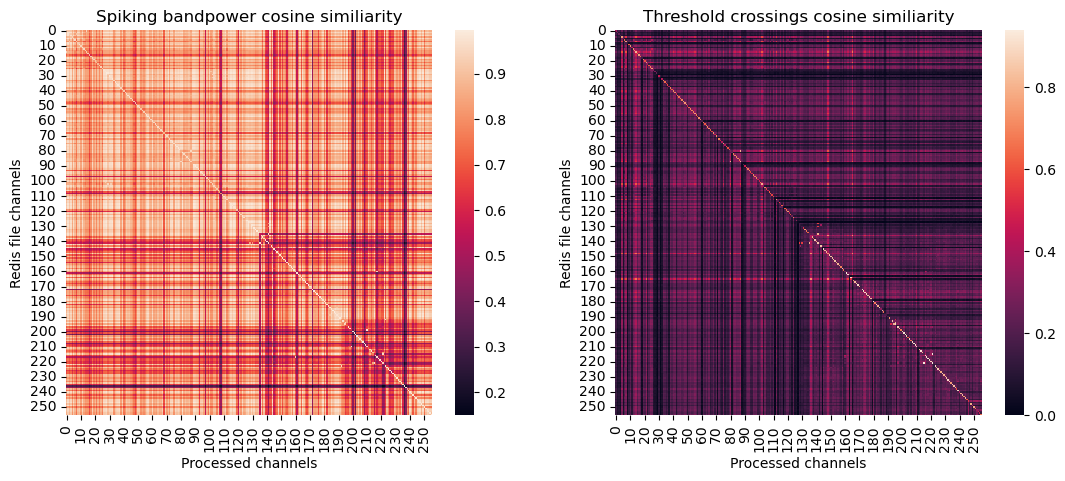

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))
sns.heatmap(ax=axs[0], data=distmatrix_cos_bandpower)
axs[0].set_title('Spiking bandpower cosine similiarity')
axs[0].set_xlabel('Processed channels')
axs[0].set_ylabel('Redis file channels')
sns.heatmap(ax=axs[1], data=distmatrix_cos_threshold)
axs[1].set_title('Threshold crossings cosine similiarity')
axs[1].set_xlabel('Processed channels')
axs[1].set_ylabel('Redis file channels')
plt.show()

In [109]:
distmatrix_euc_bandpower = _distmatrix(processed_output['bandpower'], processed['binnedNeural_hlfp'], _euclidean)
distmatrix_euc_threshold = _distmatrix(processed_output['threshold'], processed['binnedNeural'], _euclidean)

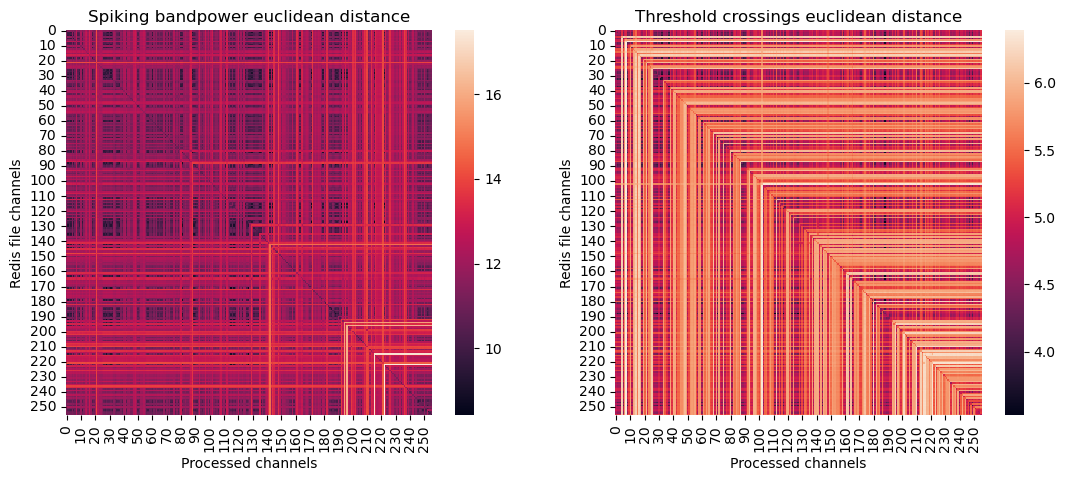

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))
sns.heatmap(ax=axs[0], data=np.log(distmatrix_euc_bandpower))
axs[0].set_title('Spiking bandpower euclidean distance')
axs[0].set_xlabel('Processed channels')
axs[0].set_ylabel('Redis file channels')
sns.heatmap(ax=axs[1], data=np.log(distmatrix_euc_threshold))
axs[1].set_title('Threshold crossings euclidean distance')
axs[1].set_xlabel('Processed channels')
axs[1].set_ylabel('Redis file channels')
plt.show()

In [3]:
processed

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Aug 13 08:26:09 2022',
 '__version__': '1.0',
 '__globals__': [],
 'binnedNeural': array([[0, 0, 0, ..., 0, 0, 3],
        [0, 0, 0, ..., 0, 1, 3],
        [0, 0, 1, ..., 0, 0, 7],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 1, 1]], dtype=uint8),
 'binnedNeural_hlfp': array([[ 437.29 ,  344.683,  360.849, ...,  498.889,  672.257, 2097.158],
        [ 417.445,  314.658,  333.663, ...,  714.822,  614.052, 1663.553],
        [ 421.063,  393.104,  385.766, ...,  658.242,  675.825, 1819.876],
        ...,
        [ 576.634,  364.713,  272.376, ...,  521.593,  621.276,  531.304],
        [ 884.003,  400.384,  342.821, ...,  533.764,  917.961,  917.408],
        [ 551.696,  393.892,  368.681, ...,  541.913, 2317.744,  849.261]],
       dtype=float32),
 'binnedNeural_xpcClock': array([[ 25100,  25120,  25140, ..., 424960, 424980, 425000]],
       dtype=uint32),
 'b

In [107]:
correlation_matrix = np.corrcoef(data, rowvar=False)

# Visualizing the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Channel Similarity Heatmap')
plt.show()

NameError: name 'data' is not defined

In [137]:
l = np.argmax(dist11, axis=0)
l.sort()
l

array([   7,   30,   50,   62,   68,   91,  136,  142,  201,  240,  268,
        279,  327,  350,  409,  411,  440,  480,  483,  504,  541,  589,
        593,  597,  643,  648,  656,  679,  686,  700,  702,  731,  741,
        754,  804,  833,  861,  883,  889,  891,  968, 1000, 1046, 1090,
       1097, 1124, 1169, 1173, 1208, 1214, 1223, 1226, 1235, 1246, 1248,
       1249, 1282, 1309, 1313, 1315, 1330, 1355, 1361, 1375, 1389, 1394,
       1395, 1399, 1405, 1406, 1421, 1425, 1427, 1429, 1433, 1437, 1438,
       1439, 1439, 1439, 1441, 1444, 1446, 1447, 1450, 1453, 1453, 1460,
       1463, 1464, 1465, 1467, 1471, 1477, 1483, 1490, 1495, 1503, 1534,
       1542, 1544, 1547, 1550, 1564, 1565, 1597, 1612, 1613, 1625, 1631,
       1636, 1638, 1642, 1656, 1659, 1671, 1671, 1677, 1685, 1702, 1712,
       1770, 1801, 1823, 1826, 1856, 1955, 1971])

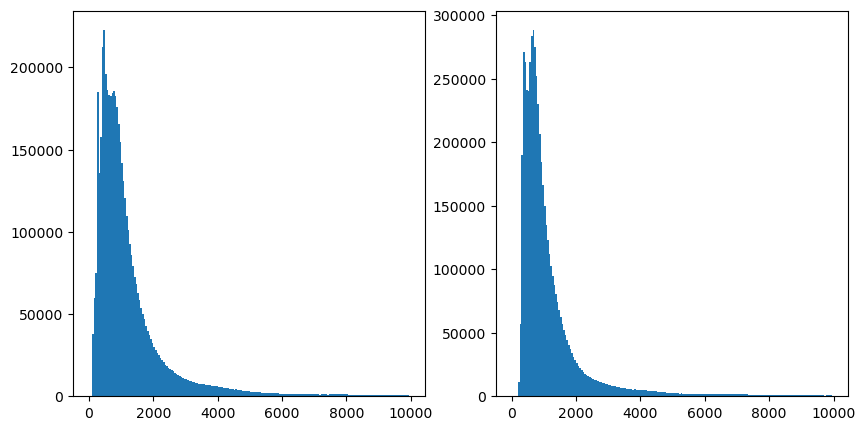

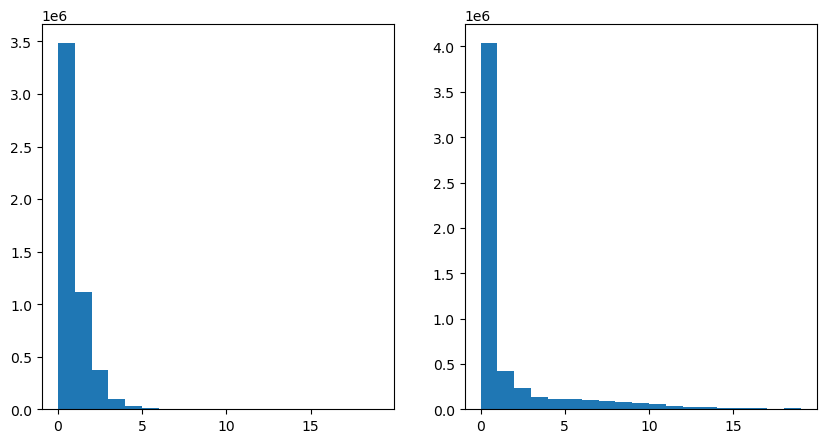

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(processed['binnedNeural'].flatten(), bins=[i for i in range(20)])
axs[1].hist(np.hstack([arr1_20ms['threshold_-4.5'].flatten(), arr2_20ms['threshold_-4.5'].flatten()]), bins=[i for i in range(20)])
plt.show()

In [33]:
@nb.jit(nopython=True)
def cross_correlate(X1, X2): 
    """
    Cross-correlates two features 
    by calculating the sliding window of 

    Args:
        X1 (_type_): [samples x channels] shape array to cross-correlate  
        X2 (_type_): [samples] shape vector to cross-correlate against
    """
    X1 = X1.astype('float32')
    X2 = X2.astype('float32')
    
    n_samples1, n_channels = X1.shape
    n_samples2 = X2.shape[0]
    n_windows = n_samples1 - n_samples2 + 1
    cross_correlated = np.zeros(shape=(n_windows, n_channels), dtype='float32')
    
    for i in range(n_windows): 
        offset = np.abs(X1[i:i+n_samples2,:] - X2[:,None])
        for ch in range(n_channels): 
            cross_correlated[i, ch] = np.sum(offset[:,ch])
            
    return cross_correlated 

@nb.jit(nopython=True)
def _euclideandist(X1, ): 
    

In [35]:
threshold_cross_correlated_arr1_ch0 = cross_correlate(arr1_20ms['threshold_-4.5'], processed['binnedNeural'][:,0])

In [38]:
threshold_cross_correlated_arr2_ch0 = cross_correlate(arr2_20ms['threshold_-4.5'], processed['binnedNeural'][:,0])

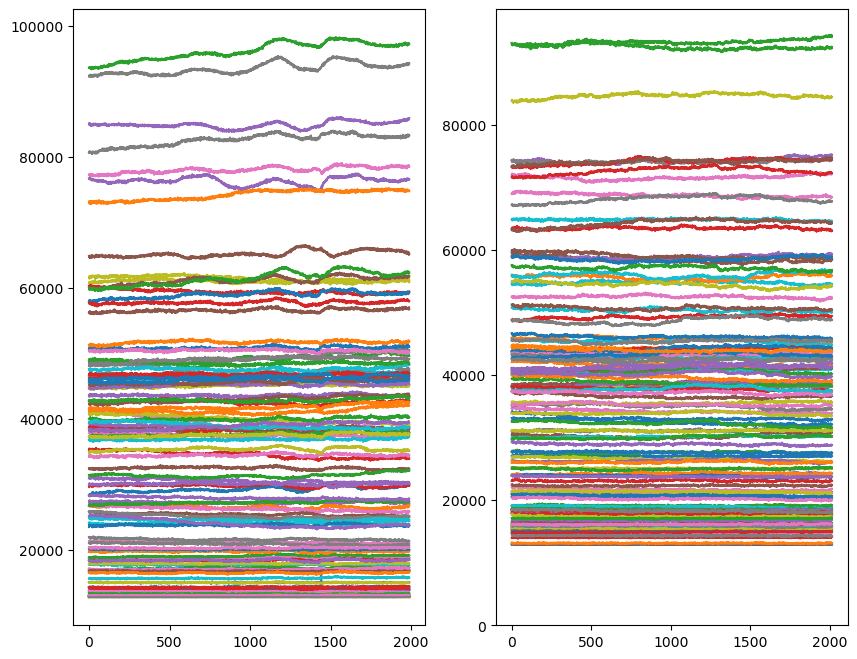

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

for ch in range(threshold_cross_correlated_arr1_ch0.shape[1]): 
    axs[0].plot(threshold_cross_correlated_arr1_ch0[:,ch])
for ch in range(threshold_cross_correlated_arr2_ch0.shape[1]): 
    axs[1].plot(threshold_cross_correlated_arr2_ch0[:,ch])
plt.ylim(bottom=0)
plt.show()

In [4]:
# Or maybe 20ms bin but one of the arrays is just has stronger bandpower in general 
processor_params_20msbin = {
    "processes": [
        ReReferenceFilter("car"), 
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True)
    ], 
    "thresh_mults": [-3.5], 
    "thresh_method": "rms",
    "spike_pow_bands": ['full'], 
    "bin_size": 20,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 20,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}
    
Processor_20 = NeuralProcessor(processor_params_20msbin)

In [5]:
arr1_20ms = Processor_20(raw_neural1, n_arrays=1, n_electrodes=128, fs=30000)
arr2_20ms = Processor_20(raw_neural2, n_arrays=1, n_electrodes=128, fs=30000)

KeyboardInterrupt: 

In [32]:
arr1_20ms

{'lfp': array([[  6.993,  -0.033,  -0.108, ...,  -0.705,   2.517,  -0.152],
        [ -6.44 ,  -4.723,   0.621, ...,  -5.05 ,   4.557,  -0.499],
        [-16.215,  -7.921,   0.958, ...,  -8.779,   6.906,  -0.635],
        ...,
        [-12.464,  -8.422,  -7.744, ...,  12.024, -16.806,  -1.773],
        [ -6.991,  -7.037,  -6.742, ...,   5.282, -13.896,  -2.3  ],
        [ -1.293,  -5.099,  -6.267, ...,  -2.942, -11.53 ,  -2.685]]),
 'bandpower_f_uHz': array([[454.162, 160.249, 140.763, ...,  95.186, 305.735, 112.295],
        [307.099, 170.611, 164.238, ...,  73.065, 214.016,  99.333],
        [361.066, 161.242, 125.864, ...,  65.157, 200.054, 142.768],
        ...,
        [286.579, 163.513, 193.403, ...,  65.49 , 173.094, 115.92 ],
        [508.781, 185.308, 125.894, ...,  76.869, 199.236, 110.118],
        [435.896, 239.583, 127.948, ...,  76.007, 332.39 ,  96.134]])}

NameError: name 'arr1_20ms' is not defined

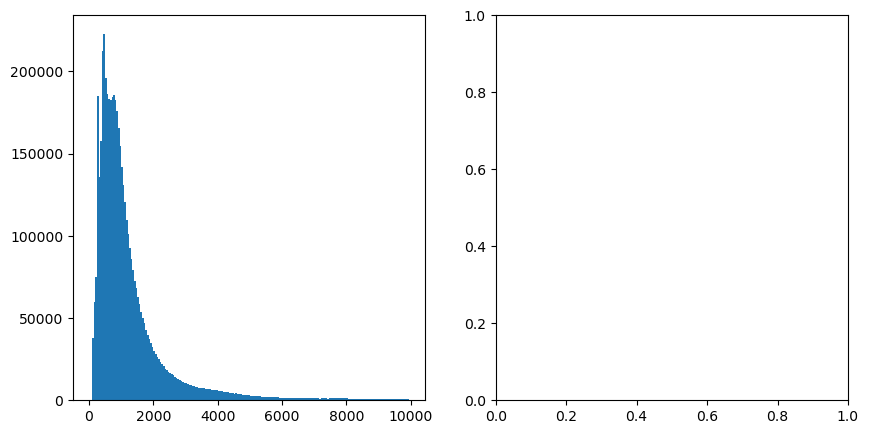

KeyError: 'threshold_-3.5'

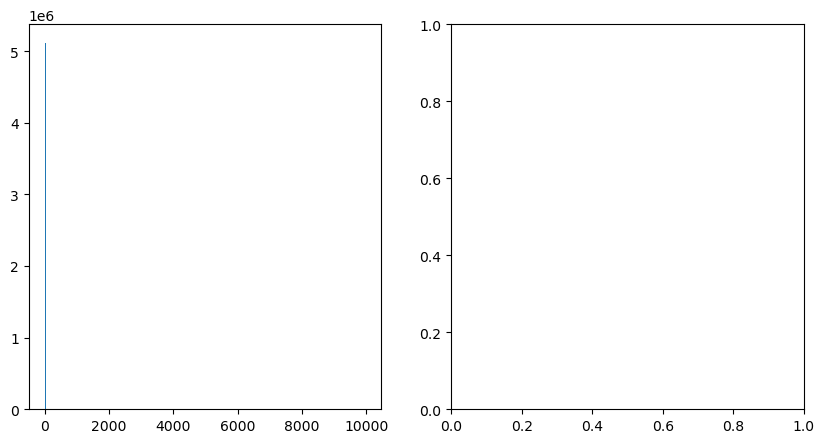

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(processed['binnedNeural'].flatten(), bins=[50*i for i in range(200)])
axs[1].hist(np.hstack([arr1_20ms['threshold_-3.5'].flatten(), arr2_20ms['threshold_-3.5'].flatten()]), bins=[50*i for i in range(200)])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(processed['binnedNeural_hlfp'].flatten(), bins=[50*i for i in range(200)])
axs[1].hist(np.hstack([arr1_20ms['bandpower_f_uHz'].flatten(), arr2_20ms['bandpower_f_uHz'].flatten()]), bins=[50*i for i in range(200)])
plt.show()

In [8]:
arr1_20ms['bandpower_f_uHz'].shape

(21984, 128)

In [7]:
arr2_20ms['bandpower_f_uHz'].shape

(22010, 128)

In [ ]:
arr1_40ms = Processor_40(raw_neural1, n_arrays=1, n_electrodes=128, fs=30000)
arr2_40ms = Processor_40(raw_neural2, n_arrays=1, n_electrodes=128, fs=30000)

In [ ]:
arr1_50ms = Processor_50(raw_neural1, n_arrays=1, n_electrodes=128, fs=30000)
arr2_50ms = Processor_50(raw_neural2, n_arrays=1, n_electrodes=128, fs=30000)

In [8]:
# Replicate the method used in Willet et al (2021)
# Outlined in https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03506-2/MediaObjects/41586_2021_3506_MOESM1_ESM.pdf

# 20 ms bin was used for decoding
processor_params_20msbin = {
    "processes": [
        ReReferenceFilter("car"), 
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True)
    ], 
    "threshold_multipliers": [-3.5], 
    "spike_pow_bands": ['full'], 
    "thresh_method": "rms",     # rms or std supported, but rms preferred                              – Optional. Only required if extracting threshold crossing count
    "bin_size": 20,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 20,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}

# 10 ms bin was used for analysis 
processor_params_10msbin = {
    # processes for denoising the signal. any permutation or process can be used.                      – Optional 
    "processes": [
        ReReferenceFilter("car"), 
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True)
    ], 
    "threshold_multipliers": [-3.5], 
    "spike_pow_bands": ['full'], 
    "thresh_method": "rms",     # rms or std supported, but rms preferred                              – Optional. Only required if extracting threshold crossing count
    "bin_size": 10,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 10,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}

Processor_10msbin = NeuralProcessor(processor_params_10msbin)
Processor_20msbin = NeuralProcessor(processor_params_20msbin)

In [9]:
# Takes about 10 mins to run 
features_20msbin = Processor_20msbin(raw_neural, n_arrays=1, n_electrodes=128, fs=30000)

In [5]:
processor_params_30 = {
    "processes": [
        ReReferenceFilter("car"), 
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True)
    ], 
    "threshold_multipliers": [-3.5], 
    "spike_pow_bands": ['full'], 
    "thresh_method": "rms",     # rms or std supported, but rms preferred                              – Optional. Only required if extracting threshold crossing count
    "bin_size": 30,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 30,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}

# 10 ms bin was used for analysis 
processor_params_40 = {
    # processes for denoising the signal. any permutation or process can be used.                      – Optional 
    "processes": [
        ReReferenceFilter("car"), 
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True)
    ], 
    "threshold_multipliers": [-3.5], 
    "spike_pow_bands": ['full'], 
    "thresh_method": "rms",     # rms or std supported, but rms preferred                              – Optional. Only required if extracting threshold crossing count
    "bin_size": 40,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 40,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}

Processor_30msbin = NeuralProcessor(processor_params_30)
Processor_40msbin = NeuralProcessor(processor_params_40)

In [6]:
# Takes about 10 mins to run 
features_30msbin = Processor_30msbin(raw_neural, n_arrays=1, n_electrodes=128, fs=30000)
features_40msbin = Processor_40msbin(raw_neural, n_arrays=1, n_electrodes=128, fs=30000)

In [8]:
processor_params_20msbin_10msshift = {
    "processes": [
        ReReferenceFilter("car"), 
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True)
    ], 
    "threshold_multipliers": [-3.5], 
    "spike_pow_bands": ['full'], 
    "thresh_method": "rms",     # rms or std supported, but rms preferred                              – Optional. Only required if extracting threshold crossing count
    "bin_size": 20,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 10,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}

Processor_20msbin_10msshift = NeuralProcessor(processor_params_20msbin_10msshift)

In [9]:
features_20msbin_10msshift = Processor_20msbin_10msshift(raw_neural, n_arrays=1, n_electrodes=128, fs=30000)

In [7]:
processor_params_20msbin_std = {
    "processes": [
        ReReferenceFilter("car"), 
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True)
    ], 
    "threshold_multipliers": [-3.5], 
    "spike_pow_bands": ['full'], 
    "thresh_method": "std",     # rms or std supported, but rms preferred                              – Optional. Only required if extracting threshold crossing count
    "bin_size": 20,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 10,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}

Processor_20msbin_std = NeuralProcessor(processor_params_20msbin_std)

In [5]:
features_20msbin_std = Processor_20msbin_std(raw_neural, n_arrays=1, n_electrodes=128, fs=30000)

In [21]:
cc_ch0_decoding = cross_correlate(features_decoding['threshold_-3.5'], processed['binnedNeural'][:,0])

In [22]:
cc_ch0_analysis = cross_correlate(features_analysis['threshold_-3.5'], processed['binnedNeural'][:,0])

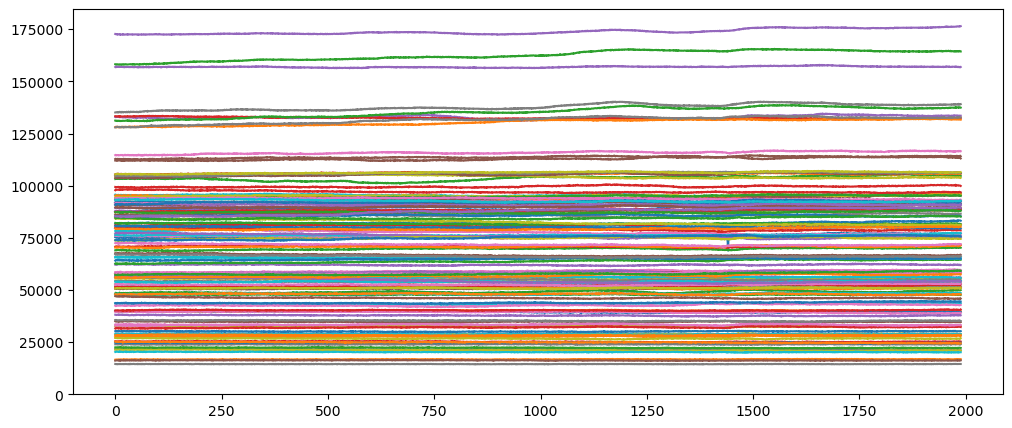

In [23]:
plt.figure(figsize=(12, 5))
for ch in range(cc_ch0_decoding.shape[1]): 
    plt.plot(cc_ch0_decoding[:,ch])
plt.ylim(bottom=0)
plt.show()

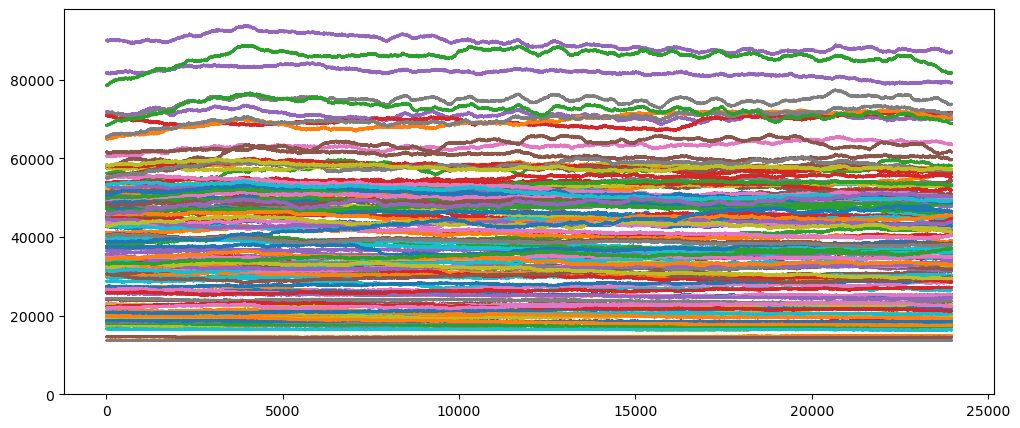

In [24]:
plt.figure(figsize=(12, 5))
for ch in range(cc_ch0_analysis.shape[1]): 
    plt.plot(cc_ch0_analysis[:,ch])
plt.ylim(bottom=0)
plt.show()

In [45]:
np.sum(features_analysis['threshold_-3.5'][:19996,:], axis=0)

array([37761., 10830., 23069.,  9582., 68367., 15371., 38031., 64607.,
        8781., 19517., 41363., 18264., 51259., 69800., 91430., 47536.,
       55337., 42773., 11037., 38236., 42855., 62418., 32315., 38929.,
       82623., 52477., 18826.,  6633.,  6873., 11473., 18093., 12005.,
        7250., 34788., 30899., 23748., 26700.,  8132., 43133., 33432.,
       46057., 52987., 21776., 40796., 45096., 41200., 37125., 42273.,
       52203., 48168., 18792., 35898., 39717., 42139., 45377., 58432.,
       37451., 15634., 45874., 36091.,  8736., 47277., 29819., 53863.,
       27695., 46655., 17276., 23395., 45417., 21876., 42014., 22035.,
       43592., 27262., 17355., 50043., 14151., 25697., 12753., 36291.,
       42694., 10132., 42247., 52210., 46227., 43220., 46288., 61623.,
       27139.,  5936., 10953., 25683., 45116., 48304., 26200., 23206.,
       49877., 50272., 53506., 27145., 31222., 39531., 78003., 26140.,
       38726., 21290., 24360., 27602., 35078., 22553., 46755.,  2891.,
      

In [15]:
processor_params_bpfirst = {
    "processes": [
        FrequencyFilter("bandpass", Wn=[250, 3000], ord=4, fs=30000, non_causal=True), 
        ReReferenceFilter("car")
    ], 
    "spike_pow_bands": ['full'], 
    "bin_size": 20,             # bin size for spiking bandpower and threshold crossing count, in ms   – Optional. Only required if extracting threshold crossing count or spike bandpower
    "shift_size": 10,           # bin shift for spiking bandpower and threshold crossing count, in ms  – Optional. Only required if extracting threshold crossing count or spike bandpower
    "fs": 30000                 # signal sampling frequency in Hz
}

Processor_bpfirst = NeuralProcessor(processor_params_bpfirst)

In [ ]:
Processor_bpfirst(raw_neural, n_arrays=1, n_electrodes=128, fs=30000)

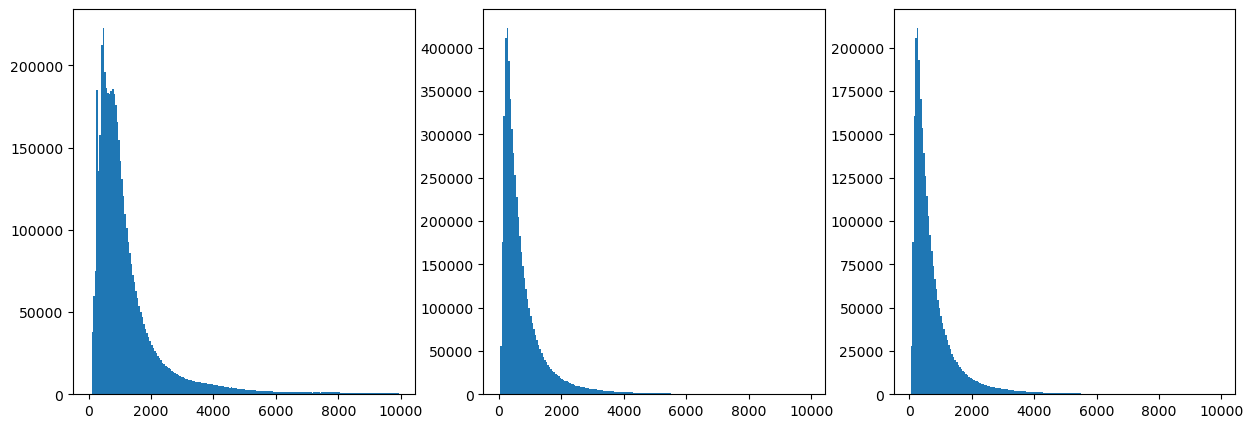

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(processed['binnedNeural_hlfp'].flatten(), bins=[50*i for i in range(200)])
axs[1].hist(features_20msbin_10msshift['bandpower_f_uHz'].flatten(), bins=[50*i for i in range(200)])
axs[2].hist(features_20msbin_std['bandpower_f_uHz'].flatten(), bins=[50*i for i in range(200)])
plt.show()

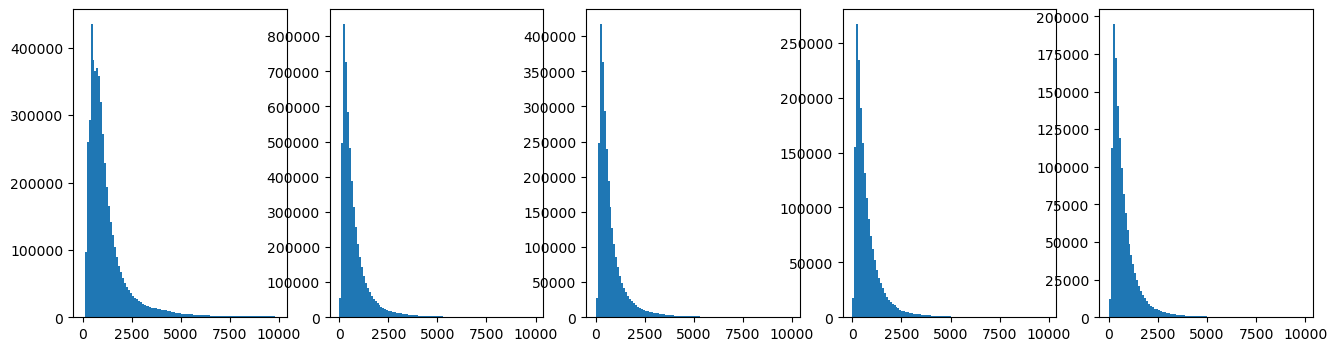

In [13]:
fig, axs = plt.subplots(1, 6, figsize=(16, 3))

axs[0].hist(processed['binnedNeural_hlfp'].flatten(), bins=[100*i for i in range(100)])
axs[1].hist(features_20msbin_10msshift['bandpower_f_uHz'].flatten(), bins=[100*i for i in range(100)])
axs[2].hist(features_20msbin['bandpower_f_uHz'].flatten(), bins=[100*i for i in range(100)])
axs[3].hist(features_30msbin['bandpower_f_uHz'].flatten(), bins=[100*i for i in range(100)])
axs[4].hist(features_40msbin['bandpower_f_uHz'].flatten(), bins=[100*i for i in range(100)])
plt.show()

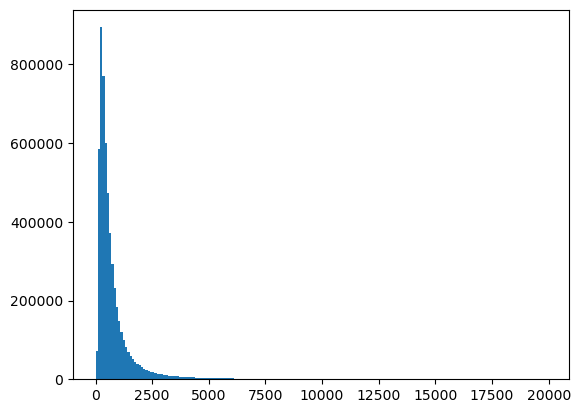

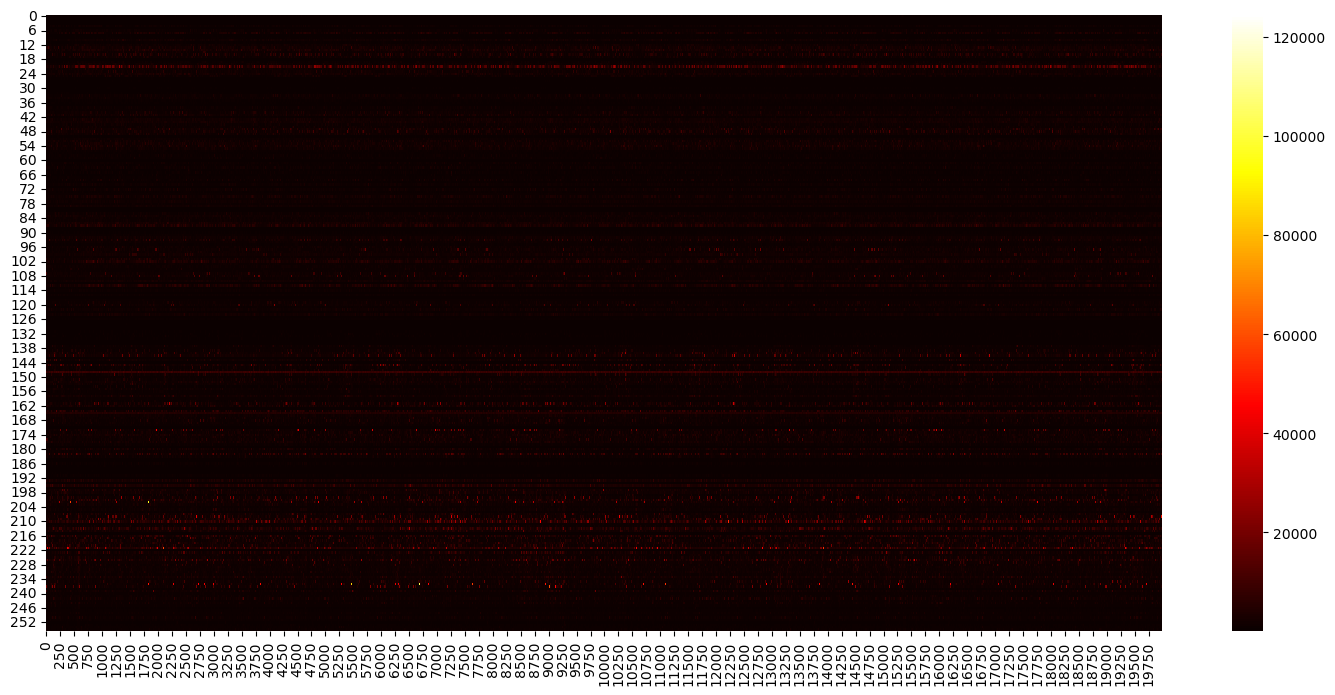

In [48]:
import seaborn as sns

plt.figure(figsize=(18, 8))
sns.heatmap(processed['binnedNeural_hlfp'].T, cmap='hot')
plt.show()

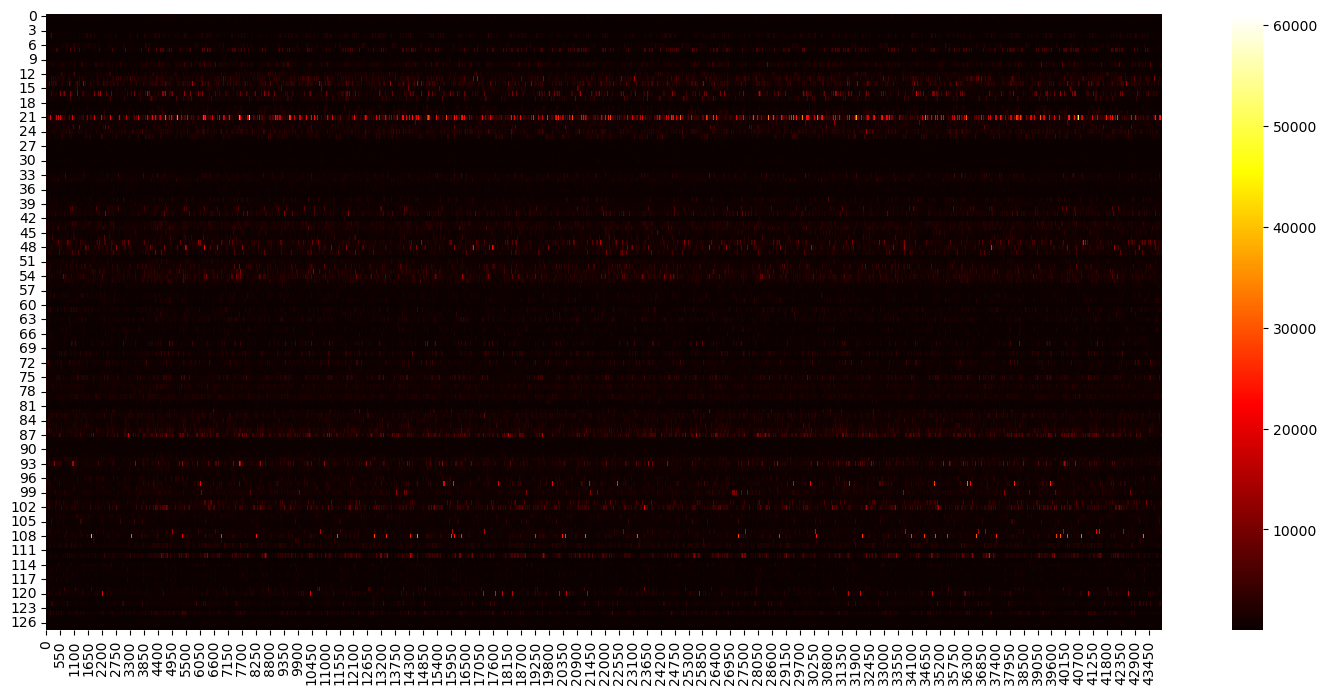

In [54]:
import seaborn as sns

plt.figure(figsize=(18, 8))
sns.heatmap(features_analysis['bandpower_f_uHz'].T, cmap='hot') 
plt.show()